# Boston Blue Bikes Data Analysis



## 1. Introduction <a class="anchor" id="introduction"></a>

Blue Bikes is a popular bike-sharing company in Massachaussettes. It provides bicycles in many neighbourhoods in MA mainly in Boston and Cambridge. Users can rent bicyles through a phone application that needs account registration. But, there are self-service digital screens at each stations which allow non-registered users to also rent bicycles. For users who rent more often, there are also several different subscription plans that they can use. After payments are processed, users are provided with codes which can be used to undock the bicycles. For normal use each 30-minutes trip costs $2.5. 


This project will look into Boston's Blue Bikes data for stations and customer to analyze any trends and obtain meaningful insight. The data is open acces and available from [BlueBikes](https://www.bluebikes.com/system-data). Some of the questions we are trying to answer are:
    
    * Is there any trend in the bike usage in time? More specifically, how bike rental changes over the years? Are there any changes in bike rentals in different seasons, months, and day of the week?
    * What are the stations with high and low usage rate? Are the starting stations with highest usage the same as the stopping stations with highest usage?
    * Are there spots over the cities that in general have more bike usage?
    * What is the age distribution of users? 
    * What are the trip duration distribution?
    * Is there any correlation between age and trip duration?
    * Is there any correlation between age and time trends of use?
    

## 2. Download and process bike share data

### 2.1. Downoald and unzip the files:

Since the links to the data have names in sequantial name orders it is much easier to download the data using bash script and wget. Using 20{15..20}{01..12} we will download from 201501 to 202012. The next cell contains the lines to download, move, and unzip the data. The commands are commented out to avoid downloading multiple times. 

In [336]:
%%bash
# wget https://s3.amazonaws.com/hubway-data/20{15..20}{01..12}-hubway-tripdata.zip
# wget https://s3.amazonaws.com/hubway-data/20{15..20}{01..12}-bluebikes-tripdata.zip
# unzip '*.zip'
# mkdir data
# mv *csv data
# rm *zip
# rm __MACOSX -rf

### 2.2 Importing and sorting the trip data files

The next couple of cells import all csv files into pandas dataframes. Then we will explore their column names to see if there are any differences between them. We do this to see if we can merge them. Finally we merge all the data frames. 


In [1]:
import pandas as pd
import glob
import os
import numpy as np
path = r'data' # use your path
all_files = glob.glob(path + "/*.csv")


In [2]:
temp = [i.split("/", 1)[1] for i in all_files]
dataframe_names = [i.split("_", 1)[0] for i in temp]
dataframe_names = [i.split("-", 1)[0] for i in dataframe_names]


Create a list of dataframes in order to compare their column name differences and merging them later. 

In [3]:
dataframes = []
for i in range(len(dataframe_names)):
    globals()["df_"+dataframe_names[i]] = pd.read_csv(all_files[i])
    dataframes.append(globals()["df_"+dataframe_names[i]])

KeyboardInterrupt: 

In [ ]:
for i in range(1,len(dataframes)):
    first_columns = dataframes[i-1].columns
    second_columns = dataframes[i].columns
    column_diffs = first_columns.difference(second_columns)
    second_column_diffs = second_columns.difference(first_columns)
    print(column_diffs)
    print(second_column_diffs)

No we want to check to see if the files have the same columns. 

So it seems that some data sets have **postal code** and the rest have **birth year** and **gender** instead. But, since they all share the rest of the columns we can simply join them all together. 

In [325]:
df_2015_2020 = pd.concat(dataframes,ignore_index=True)

### 2.3 Sorting the data

First we need to convert the timestamp columns to datatime objects. Then we sort them based on the date,

In [339]:
df_2015_2020[["starttime","stoptime"]] = df_2015_2020[["starttime","stoptime"]].apply(pd.to_datetime)


In [340]:
df_2015_2020 = df_2015_2020.sort_values(by='starttime')

## 3. Importing the station name csv file and create an interactive map of the stations. 

In [4]:
df_stations = pd.read_csv('https://s3.amazonaws.com/hubway-data/Hubway_Stations_as_of_July_2017.csv')


In [5]:
import requests
import folium
import urllib
# from pandas.io.json import json_normalize
import pandas as pd
import folium
from geopandas import GeoDataFrame
from shapely.geometry import Point


In [6]:
geometry = [Point(xy) for xy in zip(df_stations.Longitude, df_stations.Latitude)]
gdf_stations = GeoDataFrame(df_stations, crs=4326, geometry=geometry)


In [7]:
mean_lon = df_stations.Longitude.mean()
mean_lat = df_stations.Latitude.mean()

In [8]:
m = folium.Map([mean_lat, mean_lon], zoom_start= 11, tiles='cartodbpositron')
folium.GeoJson(gdf_stations).add_to(m)

m


<img src="img/Station_Maps.png" />

## 4. Data Analysis

In this section we analyze the data sets to find answer to the questions we posed in the introduction.

### 4.1 Trends in time?

In this section we check to see how usage are changing over the years, months, and daya of the week. 

#### Yearly trends!

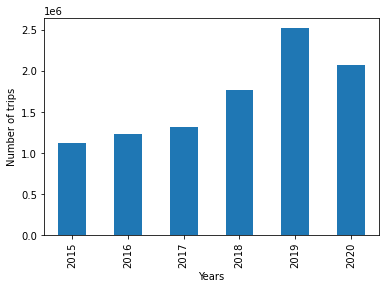

In [235]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import calendar
calendar.setfirstweekday(calendar.SUNDAY)

ax = df_2015_2020.starttime.groupby(df_2015_2020.starttime.dt.year).agg('count').plot(kind="bar", xlabel='Years', ylabel='Number of trips')

# ax = df_2015_2020_monthly_sum.plot(kind="bar")
# set monthly locator
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# # set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# # set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()

plt.savefig('Yearly_Sum_Number_of_Trips.png')

Looking at the usage rate over the years we can easily seen that usage has been grown rapidly from 2015 to 2019. Then there is a **drop in 2020**. It might be relevant to the COVID-19. We can check it out more later. 

#### Monthly usage

In [345]:
df_2015_2020_monthly_sum = df_2015_2020.set_index('starttime').resample('M', convention='end').agg({'tripduration':'sum'})

In [347]:
df_2015_2020_monthly_sum

,tripduration
starttime,
2015-01-31,5079367
2015-02-28,2843948
2015-03-31,25190823
2015-04-30,54941656
2015-05-31,149762042
...,...
2020-08-31,538516228
2020-09-30,578481998
2020-10-31,363635392


In [346]:
df_2015_2020['tripduration'].groupby(df_2015_2020["starttime"].dt.month).count()

starttime
1      278815
2      312453
3      356505
4      551646
5      933125
6     1142094
7     1338209
8     1387542
9     1388812
10    1182211
11     767998
12     397150
Name: tripduration, dtype: int64

In [349]:
df_2015_2020['smonths'] = df_2015_2020.starttime.dt.month_name()
df_2015_2020['months'] = df_2015_2020.starttime.dt.month
df_2015_2020.set_index('months').sort_index()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,postal code,smonths
months,,,,,,,,,,,,,,,,,
1,542,2015-01-01 00:21:44.000,2015-01-01 00:30:47.000,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,Subscriber,1984,1.0,NaN,January
1,859,2020-01-07 16:21:43.182,2020-01-07 16:36:02.818,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,206,Government Center - Cambridge St at Court St,42.359803,-71.059608,5435,Subscriber,1946,1.0,NaN,January
1,281,2020-01-07 16:21:28.192,2020-01-07 16:26:10.105,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,361,Deerfield St at Commonwealth Ave,42.349244,-71.097282,5493,Subscriber,2000,1.0,NaN,January
1,97,2020-01-07 16:21:27.397,2020-01-07 16:23:04.495,24,Seaport Square - Seaport Blvd at Northern Ave,42.351482,-71.044361,157,Seaport Blvd at Sleeper St,42.353178,-71.048174,5163,Subscriber,1969,1.0,NaN,January
1,442,2020-01-07 16:21:25.552,2020-01-07 16:28:48.285,380,Mass Ave at Albany St,42.361358,-71.096703,437,Berkshire Street at Cambridge Street,42.372077,-71.089954,2824,Subscriber,1987,1.0,NaN,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,552,2017-12-05 16:59:53.000,2017-12-05 17:09:05.000,107,Ames St at Main St,42.362500,-71.088220,190,Nashua Street at Red Auerbach Way,42.365673,-71.064263,843,Subscriber,1976,1.0,NaN,December
12,443,2017-12-05 16:59:34.000,2017-12-05 17:06:58.000,177,University Park,42.362648,-71.100061,105,Lower Cambridgeport at Magazine St / Riverside Rd,42.357219,-71.113872,1552,Subscriber,1991,1.0,NaN,December
12,515,2017-12-05 16:58:52.000,2017-12-05 17:07:27.000,23,Boston City Hall - 28 State St,42.358920,-71.057629,152,Ink Block - Harrison Ave at Herald St,42.345901,-71.063187,1083,Subscriber,1990,1.0,NaN,December


In [359]:
grouped_by_months = df_2015_2020.months.groupby([df_2015_2020.months,df_2015_2020.smonths]).agg('count')

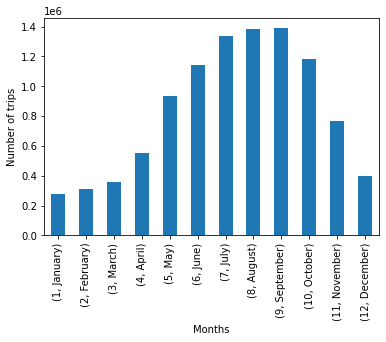

In [360]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import calendar
calendar.setfirstweekday(calendar.SUNDAY)

# grouped = df_2015_2020.starttime.groupby(df_2015_2020.starttime.dt.month_name).agg('count')

grouped_by_months.plot(kind="bar", xlabel='Months', ylabel='Number of trips')


plt.savefig('Monthly_Sum_Number_of_Trips.png')


It can be seen that the bike usage rate has a high correlation with months. It can be easily inferred that the role of seasonality on bike usage is discernable. As we are moving away from winter months the bike usage increases and reaches it's maximum during summer time between June and September and decreases again sharply in October. 

In [ ]:
df_2015_2020_monthly_sum = df_2015_2020.set_index('starttime').resample('M', convention='end').agg({'tripduration':'sum'})

In [ ]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import calendar
calendar.setfirstweekday(calendar.SUNDAY)

ax = df_2015_2020.set_index('starttime').groupby(df_2015_2020.starttime.dt.day_name()).agg('count').plot(kind="bar", xlabel='Days', ylabel='Number of trips')

# ax = df_2015_2020_monthly_sum.plot(kind="bar")
# set monthly locator
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# # set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# # set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()

plt.savefig('Daily_Sum_Number_of_Trips.png')

#### Checking 2020 for COVID effect

In [362]:
df_2020 = df_2015_2020.loc[df_2015_2020['starttime'].dt.year == 2020]

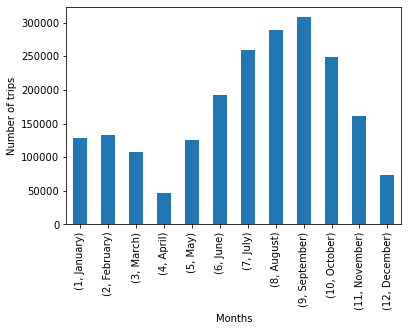

In [364]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates


df_2020.months.groupby([df_2015_2020.months,df_2015_2020.smonths]).agg('count').plot(kind="bar", xlabel='Months', ylabel='Number of trips')


# plt.savefig('Monthly_Sum_Number_of_Trips.png')


Here we can see how in April when the first stay-in-home orders were in place, bike usage had a **sharp drop**. 

### 4.2 Finding information about stations

In [366]:
df_grouped_start_station = df_2015_2020.groupby(['start station id'])

In [367]:
len(df_grouped_start_station)

442

In [369]:
len(df_stations)

330

We can see that there is a difference between the number of current stations and number of stations when we group the data from 2015 to 2020 by stations. The explanation is that **many stations have been discontinued over the years and are not shown in the df_stations.**

In [130]:
df_2015_2020.count()

tripduration               10036560
starttime                  10036560
stoptime                   10036560
start station id           10036560
start station name         10036560
start station latitude     10036560
start station longitude    10036560
end station id             10036560
end station name           10036560
end station latitude       10036560
end station longitude      10036560
bikeid                     10036560
usertype                   10036560
birth year                  8369496
gender                      8379088
postal code                 1513246
dtype: int64

In [132]:
mask_birth_date_novals = pd.to_numeric(df_2015_2020['birth year'], errors='coerce').isnull()

In [143]:
a = mask_birth_date_novals.sum()
total_rows = 10036560
print (a, " trips have no age associated with them.")
print ("%4.2f%% of trips have no age." % (a/10036560*100))
print (10036560-a)

2348042  trips have no age associated with them.
23.39% of trips have no age.
7688518


In [144]:
df_2015_2020['birth year'] = pd.to_numeric(df_2015_2020['birth year'], errors='coerce')

In [61]:
df_2015_2020['birth year'] = df_2015_2020['birth year'].fillna(1800)

In [97]:
df_2015_2020.loc[(df_2015_2020['birth year'] == "\\N"), 'birth year'] = 1800
df_2015_2020['birth year'].head(30)

5141770    1984
5141771    1985
5141772    1974
5141773    1987
5141774    1986
5141775    1989
5141776    1964
5141777    1981
5141778    1989
5141779    1993
5141780    1993
5141781    1978
5141782    1988
5141783    1988
5141784    1989
5141785    1982
5141786    1985
5141787    1991
5141788    1984
5141789    1962
5141791    1982
5141790    1800
5141792    1964
5141793    1962
5141794    1987
5141795    1986
5141796    1989
5141797    1977
5141798    1986
5141799    1800
Name: birth year, dtype: object

In [63]:
df_2015_2020.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                     object
end station name                   object
end station latitude               object
end station longitude              object
bikeid                              int64
usertype                           object
birth year                         object
gender                            float64
postal code                        object
age                                 int64
dtype: object

In [147]:
df_2015_2020['age'] = df_2015_2020.starttime.dt.year - df_2015_2020['birth year']

### To count number of NAN values in age:

In [148]:
len(df_2015_2020) - df_2015_2020['age'].count()

2348042

In [204]:
filtered_by_age_frequency = df_2015_2020[df_2015_2020.groupby('age')['age'].transform('size') > 5000]

# df_2015_2020['age'].hist(bins=40)

<AxesSubplot:>

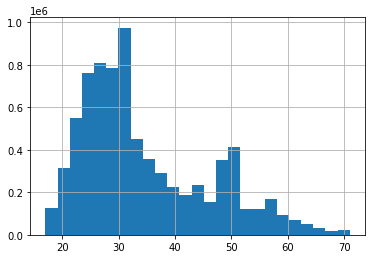

In [189]:
filtered_by_age_frequency['age'].hist(bins=25)

In [152]:
df_2015_2020['age'].value_counts()

27.0     406677
26.0     402684
28.0     402081
25.0     392537
29.0     382725
          ...  
97.0          1
102.0         1
104.0         1
87.0          1
101.0         1
Name: age, Length: 101, dtype: int64

In [161]:
len(grouped_by_age)

89

age
16.0     AxesSubplot(0.125,0.125;0.775x0.755)
17.0     AxesSubplot(0.125,0.125;0.775x0.755)
18.0     AxesSubplot(0.125,0.125;0.775x0.755)
19.0     AxesSubplot(0.125,0.125;0.775x0.755)
20.0     AxesSubplot(0.125,0.125;0.775x0.755)
                         ...                 
120.0    AxesSubplot(0.125,0.125;0.775x0.755)
126.0    AxesSubplot(0.125,0.125;0.775x0.755)
130.0    AxesSubplot(0.125,0.125;0.775x0.755)
131.0    AxesSubplot(0.125,0.125;0.775x0.755)
132.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, Length: 89, dtype: object

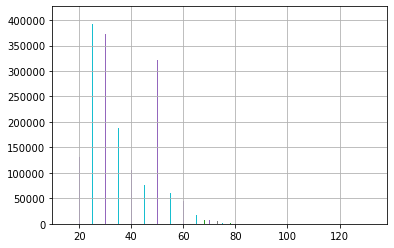

In [163]:
grouped_by_age['age'].hist()

## Working on the starting stations

In [190]:
df_2015_2020['start station id'].value_counts()

67     251774
68     194550
22     183728
80     171594
74     150172
        ...  
158         3
223         3
493         2
382         1
383         1
Name: start station id, Length: 442, dtype: int64

## Working on the duration time

In [195]:
df_2015_2020['tripduration_min'] = df_2015_2020['tripduration']//60

In [202]:
df_2015_2020['tripduration_min'].describe()

count    1.003656e+07
mean     2.714609e+01
std      1.012726e+03
min      1.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      1.900000e+01
max      7.094520e+05
Name: tripduration_min, dtype: float64

In [216]:
filtered_by_time_length = df_2015_2020.loc[df_2015_2020['tripduration'] <  1440]

In [217]:
filtered_by_time_length['tripduration_min'].describe()

count    8.288984e+06
mean     1.039503e+01
std      5.624706e+00
min      1.000000e+00
25%      6.000000e+00
50%      9.000000e+00
75%      1.400000e+01
max      2.300000e+01
Name: tripduration_min, dtype: float64

<AxesSubplot:>

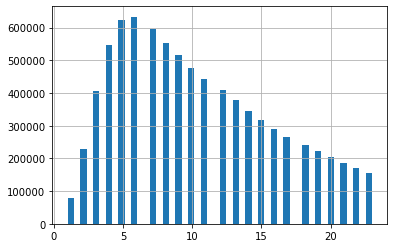

In [229]:
filtered_by_time_length['tripduration_min'].hist(bins=48)